# UTBoost Tutorial

In this tutorial, we use a synthetic dataset as demonstration data. You can find the data generation functions in this notebook.  
Please make sure that you have installed `UTBoost` and some necessary dependencies when running this tutorial.

In [1]:
import utboost as utb
from utboost import UTBClassifier, UTBRegressor

print(utb.__version__)
!python --version

0.1.6
Python 3.6.9 :: Anaconda, Inc.


## Making synthetic data

We construct a classical uplift problem, which consists of a binary classification outcome and a binary treatment indicator.  
For multi-treatment problem, please make sure that your treatment indicator starts at zero and is continuously incremented. If there is a treatment in the training data that does not have a corresponding sample, utb will not be able to process it.

In [2]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [3]:
def make_uplift_problem(
        n_samples_per_group: int = 1000,
        n_features: int = 10,
        n_informative: int = 5,
        n_uplift_mix_informative: int = 5,
        n_redundant: int = 0,
        n_repeated: int = 0,
        flip_y: float = 0.,
        pos_weight: float = 0.5,
        delta_uplift_increase: float = 0.1,
        random_seed: int = None,
):
    """
    Generate a synthetic dataset for classification uplift problem with binary treatment.

    Parameters
    ----------
    n_samples_per_group : int, optional (default=1000)
        The number of samples per group.
    n_features : int, optional (default=10)
        The total number of features.
    n_informative : int, optional (default=5)
        The number of informative features.
    n_uplift_mix_informative : int, optional (default=5)
        The number of mix features.
    n_redundant : int, optional (default=0)
        The number of redundant features.
    n_repeated : int, optional (default=0)
        The number of duplicated features, drawn randomly from the informative
        and the redundant features.
    flip_y : float, optional (default=0.)
        The fraction of samples whose class is assigned randomly.
    pos_weight : float, optional (default=0.5)
        The proportions of samples assigned to positive class.
    delta_uplift_increase : float, optional (default=0.1)
        Positive treatment effect.
    random_seed : int, optional (default=None)
        Random seed.
    Returns
    -------
    output : DataFrame
        Data frame with the treatment, label, features, and effect.
    features : list of strings
        Feature names in output.
    References
    ----------
    [1] I. Guyon, "Design of experiments for the NIPS 2003 variable selection benchmark", 2003.
    """
    if random_seed is not None:
        np.random.seed(seed=random_seed)
    # dataset dataframe
    output = pd.DataFrame()
    n_samples = n_samples_per_group * 2
    # generate treatments
    treatments = [0] * n_samples_per_group + [1] * n_samples_per_group
    treatments = np.random.permutation(treatments)
    output["treatment"] = treatments
    X1, Y1 = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative,
                                 n_redundant=n_redundant, n_repeated=n_repeated, n_clusters_per_class=1,
                                 weights=[1 - pos_weight, pos_weight], flip_y=flip_y)
    features = []
    x_informative_name = []
    for i in range(n_informative):
        x_name_i = "x" + str(len(features) + 1) + "_informative"
        features.append(x_name_i)
        x_informative_name.append(x_name_i)
        output[x_name_i] = X1[:, i]
    for i in range(n_redundant):
        x_name_i = "x" + str(len(features) + 1) + "_redundant"
        features.append(x_name_i)
        output[x_name_i] = X1[:, n_informative + i]
    for i in range(n_repeated):
        x_name_i = "x" + str(len(features) + 1) + "_repeated"
        features.append(x_name_i)
        output[x_name_i] = X1[:, n_informative + n_redundant + i]
    for i in range(n_features - n_informative - n_redundant - n_repeated):
        x_name_i = "x" + str(len(features) + 1) + "_irrelevant"
        features.append(x_name_i)
        output[x_name_i] = np.random.normal(0, 1, n_samples)
    # default treatment effects
    Y = Y1.copy()
    # generate positive uplift signal
    treatment_index = output.index[output["treatment"] == 1].tolist()
    x_uplift_increase_name = []
    adjust_class_proportion = delta_uplift_increase / (1 - pos_weight)
    X_increase, Y_increase = make_classification(n_samples=n_samples, n_features=n_informative,
                                                 n_informative=n_informative, n_redundant=0,
                                                 n_clusters_per_class=1,
                                                 weights=[1 - adjust_class_proportion, adjust_class_proportion])
    for i in range(n_informative):  # informative x
        x_name_i = "x" + str(len(features) + 1) + "_uplift_increase"
        features.append(x_name_i)
        x_uplift_increase_name.append(x_name_i)
        output[x_name_i] = X_increase[:, i]
    Y[treatment_index] = Y[treatment_index] + Y_increase[treatment_index]
    if n_uplift_mix_informative > 0:  # mix informative x
        for i in range(n_uplift_mix_informative):
            x_name_i = "x" + str(len(features) + 1) + "_uplift_increase_mix"
            features.append(x_name_i)
            output[x_name_i] = (np.random.uniform(-1, 1) * output[np.random.choice(x_informative_name)]
                                + np.random.uniform(-1, 1) * output[np.random.choice(x_uplift_increase_name)])

    Y = np.clip(Y, 0, 1)
    output['label'] = Y
    output["effect"] = Y - Y1
    return output, features


In [4]:
synthetic, x_names = make_uplift_problem(
    n_samples_per_group=20000,
    n_features=50,
    n_informative=30,
    n_redundant=5,
    flip_y=0.05,
    pos_weight=0.5,
    delta_uplift_increase=0.2,
    random_seed=616
)

In [5]:
synthetic.head()

,treatment,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_informative,x7_informative,x8_informative,x9_informative,...,x78_uplift_increase,x79_uplift_increase,x80_uplift_increase,x81_uplift_increase_mix,x82_uplift_increase_mix,x83_uplift_increase_mix,x84_uplift_increase_mix,x85_uplift_increase_mix,label,effect
0,1,6.425808,-1.164129,1.083316,-1.222816,0.652277,0.793619,0.383192,-0.429992,0.327897,...,-3.266396,1.314588,1.071352,0.119340,-1.263203,0.924545,-1.075563,-1.029562,1,0
1,0,4.563638,-3.992527,-0.962077,-3.841889,4.232803,1.477837,0.245814,6.572843,-0.006567,...,1.408347,-0.152745,-4.434943,6.035259,-2.370432,-0.428110,3.290593,-0.523953,1,0
2,1,2.635125,-8.149208,1.762120,3.301717,-0.777128,2.432556,-0.842265,2.772428,0.905667,...,2.370869,1.508215,6.428551,2.442481,1.239299,-2.287100,-5.048173,-0.269928,0,0
3,1,2.614141,2.269490,0.428034,1.242533,4.054275,-0.084977,0.639430,-2.287006,-3.934921,...,1.522768,-0.257097,-2.914597,-2.865980,-2.229839,-0.175178,2.011729,2.742500,1,0
4,0,2.131168,-7.820181,-0.504414,-0.547154,-5.020314,2.377088,0.076174,-3.193009,-2.946153,...,2.502511,-4.130155,-4.882651,-3.308974,-1.012571,-1.309999,-2.022039,1.001331,0,0


## Preparing your data

In [6]:
# Split your data into train and validation
train, valid = train_test_split(synthetic, random_state=42)

# values extraction
X_train, y_train, T_train = train.loc[:, x_names].values, train.loc[:, 'label'].values, train.loc[:, 'treatment'].values
X_valid, y_valid, T_valid = valid.loc[:, x_names].values, valid.loc[:, 'label'].values, valid.loc[:, 'treatment'].values

## Selecting the algorithm

Possible options for boosting (`ensemble_type='boosting`):
1. `criterion='gbm'` -> CausalGBM
2. `criterion='ddp'` -> TDDP

Possible options for bagging (`ensemble_type='bagging`):
1. `criterion='gbm'` -> CausalGBM (The gradient is constant and not updated)
2. `criterion='ddp'` -> Uplift random forest (delta-delta-p)
3. `criterion='ed'` -> Uplift random forest (Euclidean Distance)
4. `criterion='kl'` -> Uplift random forest (KL Divergence)
5. `criterion='chi'` -> Uplift random forest (Chi-Square statistic)

## Model Building and Training

In addition to the usual tree model parameters, such as `max_depth` and `iterations`, UTBoost also provides parameters specific to causal problems, such as whether or not to use monotonicity constraints on causal effects (`effect_constrains`), etc.   
You can refer to the parameter annotations of the corresponding functions for more information, so we won't go into it too much here.

In [7]:
# define model
# For regression problem, you should use `UTBRegressor`, not `UTBClassifier`.
model = UTBClassifier(
    ensemble_type='boosting',
    criterion='gbm',
    iterations=100,
    max_depth=4, 
    eval_metric=['qini_coff']
)

In [8]:
# train model
model.fit(
    X=X_train, 
    ti=T_train, 
    y=y_train, 
    eval_sets=[(X_valid, T_valid, y_valid)]
)

   0:	train-qini_coff: 0.088136	valid-0-qini_coff: 0.086238	total: 0.01s
   1:	train-qini_coff: 0.093118	valid-0-qini_coff: 0.095320	total: 0.01s
   2:	train-qini_coff: 0.107277	valid-0-qini_coff: 0.105780	total: 0.02s
   3:	train-qini_coff: 0.108615	valid-0-qini_coff: 0.107065	total: 0.03s
   4:	train-qini_coff: 0.112787	valid-0-qini_coff: 0.109320	total: 0.03s
   5:	train-qini_coff: 0.117081	valid-0-qini_coff: 0.115149	total: 0.04s
   6:	train-qini_coff: 0.116534	valid-0-qini_coff: 0.116476	total: 0.05s
   7:	train-qini_coff: 0.122877	valid-0-qini_coff: 0.121372	total: 0.05s
   8:	train-qini_coff: 0.128143	valid-0-qini_coff: 0.126253	total: 0.06s
   9:	train-qini_coff: 0.129083	valid-0-qini_coff: 0.126179	total: 0.06s
  10:	train-qini_coff: 0.132188	valid-0-qini_coff: 0.128736	total: 0.07s
  11:	train-qini_coff: 0.134702	valid-0-qini_coff: 0.131604	total: 0.08s
  12:	train-qini_coff: 0.141538	valid-0-qini_coff: 0.138290	total: 0.09s
  13:	train-qini_coff: 0.142422	valid-0-qini_coff: 

## Uplift prediction

The predicted output of UTBoost is the potential outcome prediction under the corresponding treatment, and you can get an estimate of the causal effect by simple calculation.

In [9]:
preds = model.predict(X_valid)
uplift_preds = preds[:, 1] - preds[:, 0]

print('Outcome shape: ', preds.shape)
print('Uplift shape: ', uplift_preds.shape)

Outcome shape:  (10000, 2)
Uplift shape:  (10000,)


## Evaluation with sklift
sklift provides common evaluation metrics that we can use to assess the performance of the model.

sklift: https://github.com/maks-sh/scikit-uplift

In [10]:
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve

Qini Score: 0.1869933887175378


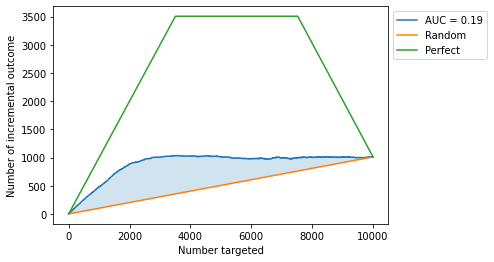

In [11]:
print("Qini Score:", qini_auc_score(y_valid, uplift_preds, T_valid))
plot_qini_curve(
    y_true=y_valid,
    uplift=uplift_preds,
    treatment=T_valid,
    perfect=True
)

## Save model to file

In [12]:
model.save_model('./model.utm')

## Load model from file

In [13]:
model = UTBClassifier().load_model('./model.utm')